<h1>C4 Solution</h1>

<h3>Get the data and copy it to S3</h3>

In [1]:
%%capture
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip

In [2]:
%%capture
!unzip dogImages.zip

In [3]:
%%capture
!aws s3 cp dogImages s3://c4-operational-ml-sagemaker-bucket/ --recursive

<h3>Install and import</h3>

In [1]:
%%capture
!pip install smdebug torch torchvision tqdm
!pip install --upgrade pandas

In [2]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
import os

<h3>Set up parameters, estimator, and tuner</h3>

In [3]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [5]:
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='pytorch_dog_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=10,
    max_parallel_jobs=3,
    objective_type=objective_type,
    early_stopping_type="Auto"
)

<h3>Fit the tuner</h3>

In [6]:
os.environ['SM_CHANNEL_TRAINING']='s3://c4-operational-ml-sagemaker-bucket/'
os.environ['SM_MODEL_DIR']='s3://c4-operational-ml-sagemaker-bucket/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://c4-operational-ml-sagemaker-bucket/output/'
tuner.fit({"training": "s3://c4-operational-ml-sagemaker-bucket/"})

...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


<h3>Describe the tuning results</h3>


In [7]:
from sagemaker.analytics import HyperparameterTuningJobAnalytics

exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-211231-0130')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

batch_size  learning_rate                            TrainingJobName  \
6      "256"       0.003733  pytorch-training-211231-0130-004-7a54168a   
9      "128"       0.004939  pytorch-training-211231-0130-001-ab117496   
3       "32"       0.100000  pytorch-training-211231-0130-007-250f2efb   
5       "32"       0.021565  pytorch-training-211231-0130-005-615494ff   
0      "512"       0.072473  pytorch-training-211231-0130-010-0d7a6268   
1      "512"       0.075889  pytorch-training-211231-0130-009-18f51479   
2      "512"       0.015402  pytorch-training-211231-0130-008-b94654b7   
4      "512"       0.016128  pytorch-training-211231-0130-006-acd7cc16   
7      "512"       0.049726  pytorch-training-211231-0130-003-fc8215db   
8      "512"       0.067633  pytorch-training-211231-0130-002-e0b63245   

  TrainingJobStatus  FinalObjectiveValue         TrainingStartTime  \
6         Completed                387.0 2021-12-31 01:38:06+00:00   
9         Completed                189.0 2021-12-31 01:33:01+00:00   
3         Completed                151.0 2021-12-31 02:00:25+00:00   
5         Completed                150.0 2021-12-31 01:38:43+00:00   
0            Failed                  NaN 2021-12-31 02:07:26+00:00   
1            Failed                  NaN 2021-12-31 02:01:49+00:00   
2            Failed                  NaN 2021-12-31 02:01:32+00:00   
4            Failed                  NaN 2021-12-31 01:56:20+00:00   
7            Failed                  NaN 2021-12-31 01:32:51+00:00   
8            Failed                  NaN 2021-12-31 01:33:10+00:00   

            TrainingEndTime  TrainingElapsedTimeSeconds  
6 2021-12-31 01:58:32+00:00                      1226.0  
9 2021-12-31 01:53:07+00:00                      1206.0  
3 2021-12-31 02:19:38+00:00                      1153.0  
5 2021-12-31 01:57:19+00:00                      1116.0  
0 2021-12-31 02:10:19+00:00                       173.0  
1 2021-12-31 02:04:14+00:00                       145.0  
2 2021-12-31 02:04:14+00:00                       162.0  
4 2021-12-31 01:59:28+00:00                       188.0  
7 2021-12-31 01:35:21+00:00                       150.0  
8 2021-12-31 01:36:07+00:00                       177.0

## Imp: If kernel dies, how to continue from a completed training job

In [8]:
#BetterTrainingJobName='pytorch-training-210623-2156-001-fdd5e081'

In [9]:
#my_estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)


In [10]:
#my_estimator.hyperparameters()

In [11]:
#best_estimator=my_estimator

<h3>Prepare to perform Training on Best Estimator</h3>

In [8]:
best_estimator=tuner.best_estimator()


2021-12-31 01:57:19 Starting - Preparing the instances for training
2021-12-31 01:57:19 Downloading - Downloading input data
2021-12-31 01:57:19 Training - Training image download completed. Training in progress.
2021-12-31 01:57:19 Uploading - Uploading generated training model
2021-12-31 01:57:19 Completed - Training job completed


In [9]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'learning_rate': '0.02156477158398731',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_dog_hpo-2021-12-31-01-30-18-378"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-458321598126/pytorch_dog_hpo-2021-12-31-01-30-18-378/source/sourcedir.tar.gz"'}

In [10]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['learning_rate']}
hyperparameters

{'batch_size': 32, 'learning_rate': '0.02156477158398731'}

In [11]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [12]:
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

<h2>Creating an Estimator</h2>

In [13]:
#adjust this cell to accomplish multi-instance training
estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='dog-pytorch',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [14]:
estimator.fit({"training": "s3://c4-operational-ml-sagemaker-bucket/"}, wait=False)

<h2>Creating an Estimator - Multi-Instance Training,</h2>

In [30]:
###in this cell, create and fit an estimator using multi-instance training
import copy
hyperparametersM = copy.deepcopy(hyperparameters)
hyperparametersM['backend'] = 'gloo'
instance_count = 4
estimatorM = PyTorch(
    entry_point='hpo.py',
    base_job_name='dog-pytorch',
    role=role,
    instance_count=instance_count,
    instance_type='ml.m5.2xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparametersM,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [31]:
estimator.fit({"training": "s3://c4-operational-ml-sagemaker-bucket/"}, wait=True)

2021-12-31 03:02:41 Starting - Starting the training job...
2021-12-31 03:03:09 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2021-12-31 03:04:09 Starting - Preparing the instances for training......
2021-12-31 03:05:10 Downloading - Downloading input data.........
2021-12-31 03:06:33 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-31 03:06:34,726 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-12-31 03:06:34,729 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-12-31 03:06:34,740 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-12-31 03:06:34,743 sagemaker_pytorch_container.training IN

<h2>Deployment</h2>

In [32]:
model_location=estimator.model_data


In [33]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


In [34]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [35]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='infernce2.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [36]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')


------!

In [37]:
import requests
#request_dict={ "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" }
request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

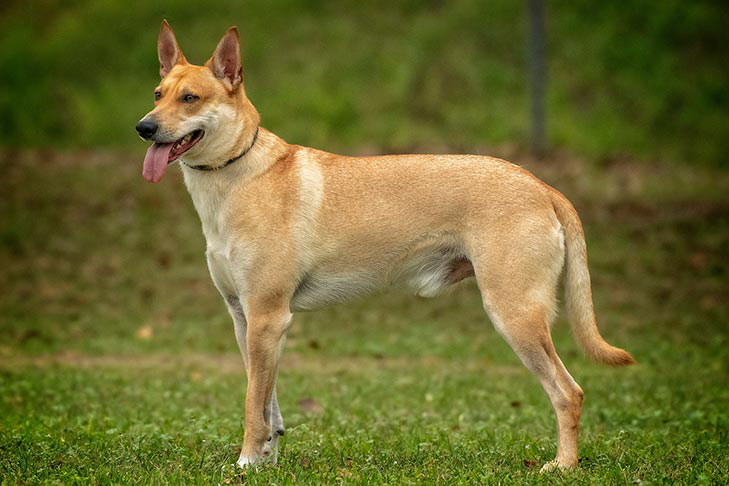

In [38]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [39]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [40]:
import json
response2=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [41]:
type(response2[0][0])

float

In [42]:
response2[0]

[0.34734490513801575,
 0.0825154185295105,
 -0.015964975580573082,
 0.10124894976615906,
 0.4444051682949066,
 0.07838094979524612,
 0.04877639189362526,
 0.29613301157951355,
 -0.40921342372894287,
 0.0937170684337616,
 0.23891182243824005,
 0.306747704744339,
 -0.07969977706670761,
 0.25712716579437256,
 0.08808896690607071,
 0.1422262340784073,
 0.32506975531578064,
 0.09944254904985428,
 -0.023919377475976944,
 0.012624005787074566,
 0.16739806532859802,
 -0.2414265125989914,
 0.05223078280687332,
 0.12266317754983902,
 -0.14728006720542908,
 -0.28513336181640625,
 0.2292458713054657,
 -0.2556290030479431,
 0.36667725443840027,
 -0.009372502565383911,
 0.10678636282682419,
 0.28420451283454895,
 -0.09753359854221344,
 0.03866459056735039,
 0.036139391362667084,
 0.21905146539211273,
 0.027788177132606506,
 0.08142882585525513,
 0.34699931740760803,
 0.19755525887012482,
 0.18417532742023468,
 0.31023144721984863,
 -0.008536187000572681,
 0.13924096524715424,
 -0.033352505415678024,

In [43]:
import torch
import numpy as np
np.argmax(response, 1)

array([4])